In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_test.csv
/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_train.csv


#### **Importing the visualization libraries**

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

#### **Loading the dataset**

In [3]:
corona_df = pd.read_csv('/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_train.csv')

#### **Exploring the dataset** 

In [4]:
corona_df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


**Here are some of the observations:**<br>
* The target variable,'Sentiment', needs to be label encoded.
* The feature 'OriginalTweet' needs to be cleaned as follows:<br>
    1. Remove twitter handle and username.
    2. Remove urls
    3. Remove html tags
    4. Remove punctuations
    5. Remove spacy stopwords and lemmatize

In [5]:
np.shape(corona_df)

(41157, 6)

#### **Before proceeding to the text preprocessing, performing EDA to understand the data better.**

In [6]:
missing_data = corona_df.isnull().sum().sort_values(ascending=False)
labels = corona_df.isnull().sum().sort_values(ascending=False).index
percent_missing = (missing_data/len(corona_df))*100

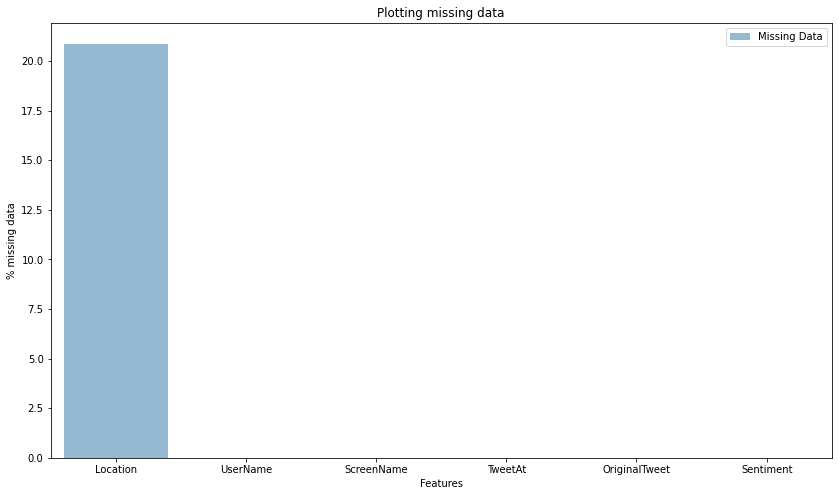

In [7]:
plt.figure(figsize=(14,8))
plt.xlabel("Features")
plt.ylabel("% missing data")
sns.barplot(x = labels,y = percent_missing,label='Missing Data',palette='Blues_d')
plt.title("Plotting missing data")
plt.legend(loc='best')

#### **Replacing all the missing values with the label 'Not Available' and getting a visual representation of the locations of tweets.**

In [8]:
corona_df['Location'].fillna("Not Available",inplace=True)

In [9]:
corona_df['Location'].isnull().sum()

0

In [10]:
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import folium
from folium import plugins

In [11]:
locations = corona_df.Location.value_counts()[1:26]
locations = pd.DataFrame(locations)
locations = locations.reset_index()
locations.columns = ['place','count']

In [12]:
geolocator = Nominatim(user_agent = 'Location Map')
geocode = RateLimiter(geolocator.geocode,min_delay_seconds=1)

In [13]:
latitude = {}
longitude = {}
for place in locations.place.values:
    location = geocode(place)
    latitude[place] = location.latitude
    longitude[place] = location.longitude
locations['latitude'] = locations.place.map(latitude)
locations['longitude'] = locations.place.map(longitude)

In [14]:
location_map = folium.Map(location=[0.7,0.7],zoom_start=2)
markers = 2

for i,row in locations.iterrows():
    loss = row['count']
    if loss>0:
        count = loss*0.05
    folium.CircleMarker([float(row['latitude']),float(row['longitude'])],radius=float(count),color='red',fill = True).add_to(location_map)

In [15]:
location_map

#### **Preprocessing the data**

In [16]:
import re
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import string

In [17]:
print(f"The stop words are:\n{STOP_WORDS}\n and the total words are:{len(STOP_WORDS)}")

The stop words are:
{'among', 'still', 'together', 'nowhere', 'does', 'meanwhile', 'thereafter', 'upon', 'front', 'whole', 'eleven', 'various', 'herein', 'been', 'myself', 'less', 'and', "'ve", 'hereupon', 'into', 'n‘t', '’re', 'along', 'i', 'one', 'their', 'something', 'give', 'all', 'of', 'third', 'four', 'twelve', 'were', 'whoever', 'neither', '’s', 'forty', 'more', 'your', 'namely', 'make', 'former', '’d', 'never', 'the', 'per', 'everywhere', 'under', '‘d', 'afterwards', 'them', 'must', 'her', 'somewhere', 'became', 'indeed', 'now', 'until', 'back', 'toward', 'there', 'rather', 'whence', 'am', 'how', "'m", 'already', 'using', 'nevertheless', 'itself', 'well', 'within', 'name', 'becoming', 'about', 'who', 'over', 'we', 'cannot', 'thereupon', 'therefore', 'if', 'latterly', 'thus', 'being', 'yet', 'wherein', 'some', 'then', 'though', 'towards', 'formerly', 'whereby', '‘re', 'always', 'ten', 'no', 'empty', 'him', 'sixty', 'could', 'during', 'where', 'used', 'least', 'beforehand', '’m',

In [18]:
stop_words = set(STOP_WORDS)-set(['not'])

In [19]:
nlp = spacy.load("en_core_web_sm")
punctuations = string.punctuation

In [20]:
def clean_data(tweet):
    remove_handle = re.sub(r'@\S+','',tweet)
    remove_urls = re.sub(r'https?://\S+','',remove_handle)
    remove_html_tags = re.sub(r'</?\w+>','',remove_urls)
    remove_punctuations = remove_html_tags.translate(str.maketrans('','',punctuations))
    doc = nlp(remove_punctuations)
    return " ".join([token.lemma_ for token in doc if token not in stop_words])

In [21]:
print(f"Before cleaning: {corona_df['OriginalTweet'][0]}")

Before cleaning: @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8


In [22]:
print(f"After cleaning: {clean_data(corona_df['OriginalTweet'][0])}") 

After cleaning:      and   and


#### **The first record has been cleaned and displayed as a sample. Doing this for the whole series after converting the data to lower-case.**

In [23]:
corona_df['OriginalTweet'] = corona_df['OriginalTweet'].str.lower()

In [24]:
corona_df['OriginalTweet'] = corona_df['OriginalTweet'].apply(lambda tweet:clean_data(tweet))

In [25]:
corona_df.OriginalTweet

0                                                and   and
1        advice talk to -PRON- neighbour family to exch...
2        coronavirus australia woolworth to give elderl...
3        -PRON- food stock be not the only one which be...
4        -PRON- ready to go at supermarket during the c...
                               ...                        
41152    airline pilot offer to stock supermarket shelf...
41153    response to complaint not provide cite covid19...
41154    -PRON- know its get tough when    be ration t...
41155    be -PRON- wrong that the smell of hand sanitiz...
41156      well newused rift s be go for 70000 on amazo...
Name: OriginalTweet, Length: 41157, dtype: object

#### **Creating wordclouds to represent the most commonly found words in each sentiment category**

In [26]:
from wordcloud import WordCloud

In [27]:
def get_token(target):
    tokens = ""
    for tweet in corona_df[corona_df['Sentiment']==target]['OriginalTweet'].str.split():
        tokens+=" ".join(tweet)
    return tokens

In [28]:
extremely_negative_reviews = get_token('Extremely Negative')
negative_reviews = get_token('Negative')
neutral_reviews = get_token('Neutral')
positive_reviews = get_token('Positive')
extremely_positive_reviews = get_token('Extremely Positive')

In [29]:
word_cloud = WordCloud(background_color='black',max_font_size=50)

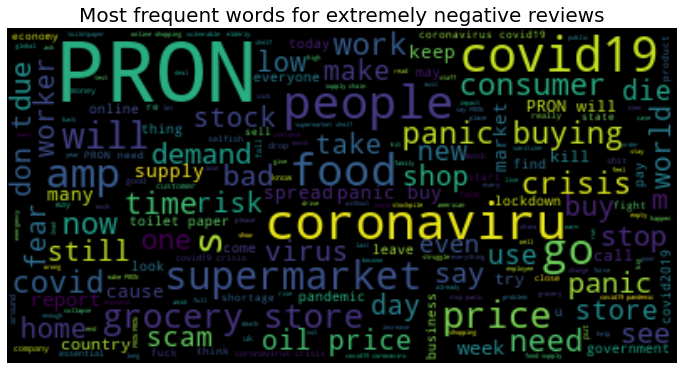

In [30]:
plt.figure(figsize=(12,10))
word_cloud.generate(extremely_negative_reviews)
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most frequent words for extremely negative reviews', fontsize=20)
plt.show()

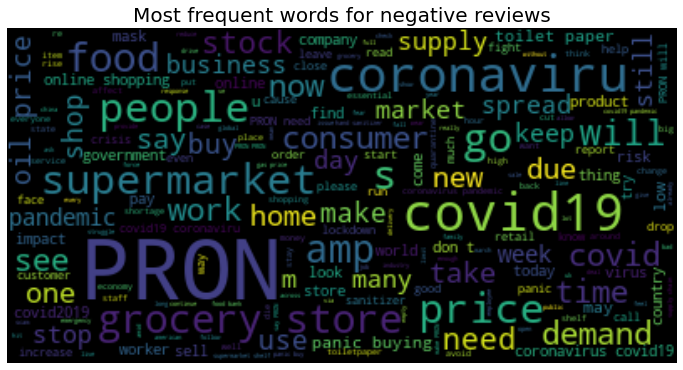

In [31]:
plt.figure(figsize=(12,10))
word_cloud.generate(negative_reviews)
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most frequent words for negative reviews', fontsize=20)
plt.show()

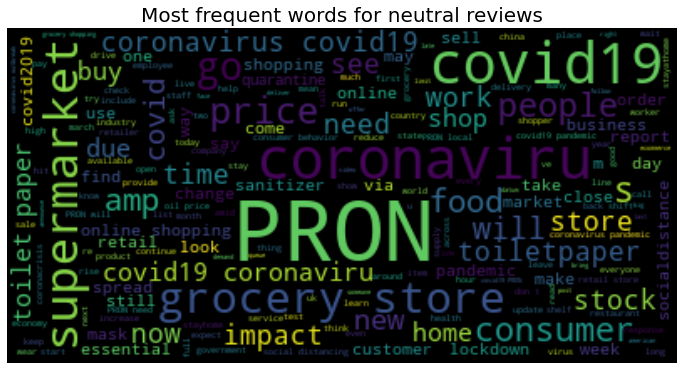

In [32]:
plt.figure(figsize=(12,10))
word_cloud.generate(neutral_reviews)
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most frequent words for neutral reviews', fontsize=20)
plt.show()

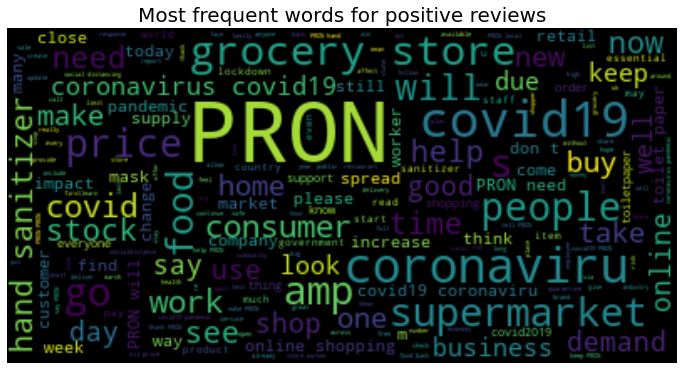

In [33]:
plt.figure(figsize=(12,10))
word_cloud.generate(positive_reviews)
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most frequent words for positive reviews', fontsize=20)
plt.show()

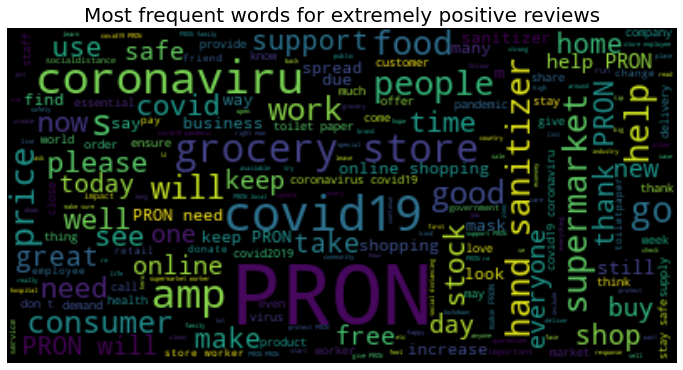

In [34]:
plt.figure(figsize=(12,10))
word_cloud.generate(extremely_positive_reviews)
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most frequent words for extremely positive reviews', fontsize=20)
plt.show()

#### Encoding the target variable. This can be done in two ways:
1. Using sklearn's label encoder
2. Using a map to transform the data into labels. Using this method.

In [35]:
def encode_target(target):
    if target=='Extremely Negative':
        return 0
    if target=='Negative':
        return 1
    if target=='Neutral':
        return 2
    if target=='Positive':
        return 3
    if target=='Extremely Positive':
        return 4

In [36]:
corona_df['Sentiment'] = corona_df['Sentiment'].apply(lambda sentiment: encode_target(sentiment))
corona_df['Sentiment']

0        2
1        3
2        3
3        3
4        0
        ..
41152    2
41153    0
41154    3
41155    2
41156    1
Name: Sentiment, Length: 41157, dtype: int64

In [37]:
from plotly.offline import iplot
import cufflinks as cf

In [38]:
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

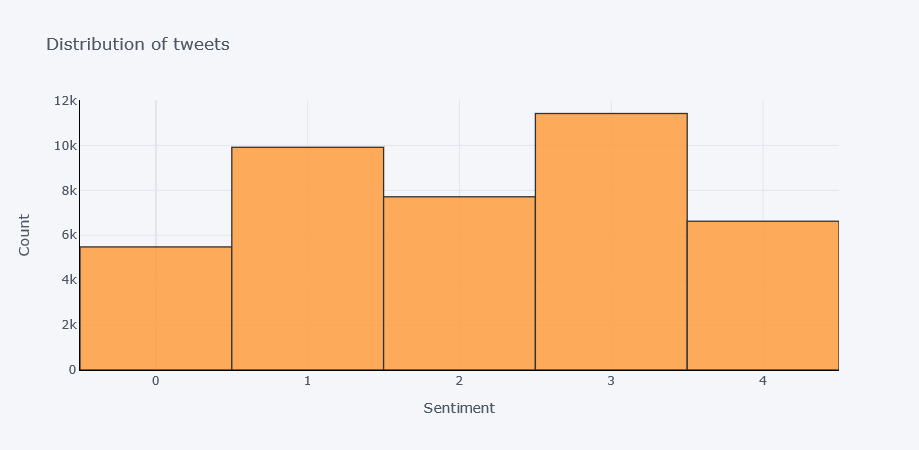

In [39]:
corona_df['Sentiment'].iplot(kind='hist',xTitle='Sentiment',yTitle='Count',linecolor='black',title='Distribution of tweets')

#### Performing word-embedding and using TfIdf Vectorizer for this purpose. Since this is a small dataset, it is not necessary to use deep learning.

In [40]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [41]:
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(corona_df['OriginalTweet'])
Y = corona_df.Sentiment

In [42]:
from sklearn.model_selection import train_test_split as tts, cross_val_score
X_train,X_test,Y_train,Y_test = tts(X,Y,test_size=0.25,random_state=0)

#### Building the classifiers:
- Logistic Regression
- Random Forest 
- XGBoost

#### **Importing the classifiers**

In [43]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

#### **Importing the metrics**

In [44]:
from sklearn.metrics import confusion_matrix,classification_report,roc_auc_score

In [45]:
def build_model(classifier):
    classifier.fit(X_train,Y_train)
    Y_pred = classifier.predict(X_test)
    Y_pred_prob = classifier.predict_proba(X_test)
    print(f"Confusion Matrix for {classifier} model:\n {confusion_matrix(Y_test,Y_pred)}\n")
    print(f"Classification Report for {classifier} model:\n {classification_report(Y_test,Y_pred)}\n")
    print(f"ROC-AUC score for for {classifier} model:\n {roc_auc_score(Y_test,Y_pred_prob,multi_class='ovr')}\n")

In [46]:
logit = LogisticRegression(solver='liblinear')
rf = RandomForestClassifier(n_estimators=100)
xgb = XGBClassifier(n_estimators=100,learning_rate=0.01)
classifiers = [logit,rf,xgb]

In [47]:
for classifier in classifiers:
    build_model(classifier)

Confusion Matrix for LogisticRegression(solver='liblinear') model:
 [[ 677  513   62   78   14]
 [ 279 1221  361  552   77]
 [  16  205 1282  371   27]
 [  59  430  390 1624  392]
 [   8   53   60  650  889]]

Classification Report for LogisticRegression(solver='liblinear') model:
               precision    recall  f1-score   support

           0       0.65      0.50      0.57      1344
           1       0.50      0.49      0.50      2490
           2       0.59      0.67      0.63      1901
           3       0.50      0.56      0.53      2895
           4       0.64      0.54      0.58      1660

    accuracy                           0.55     10290
   macro avg       0.58      0.55      0.56     10290
weighted avg       0.56      0.55      0.55     10290


ROC-AUC score for for LogisticRegression(solver='liblinear') model:
 0.8412861840954017

Confusion Matrix for RandomForestClassifier() model:
 [[ 417  581   72  261   13]
 [ 120 1147  348  830   45]
 [  16  220 1160  492   13]


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[18:04:02] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Confusion Matrix for XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None) model:
 [[ 508  277  101  421   37]
 [ 315  589  431 1054  101]
 [  26   59 1007  777   32]
 [  99  276  4

#### **Out of the three models, the Logistic Regression model has performed the best and is closely followed by the random forest model. Performing hyper-parameter tuning to improve the performance.**

#### **The method used for tuning is the bayesian optimization algorithm. The advantages are:**
- It is faster and more accurate than random search and grid search CV.
- It uses probability to choose the optimal values for hyper-parameters such that the loss function is minimized in an efficient manner.
- There are three parameters that this method takes:
    1. Domain Space - This contains the hyperparameter values.
    2. Optimization Algorithm - The three classifiers being built.
    3. The function - Which is to be minimized.
    

In [48]:
from hyperopt import hp,fmin,tpe,STATUS_OK,Trials

In [49]:
space_rf = {'criterion':hp.choice('criterion',['entropy','gini']),
         'max_depth':hp.quniform('max_depth',10,500,10),
         'max_features':hp.choice('max_features',['auto','sqrt','log2']),
         'n_estimators':hp.choice('n_estimators',[10,50,100,150,200,300]),
         'min_samples_leaf':hp.uniform('min_samples_leaf',0,0.5)}

In [51]:
def objective_rf(space):
    model = RandomForestClassifier(n_estimators = space['n_estimators'],criterion=space['criterion'],max_depth=space['max_depth'],min_samples_leaf=space['min_samples_leaf'])
    accuracy = cross_val_score(model,X_train,Y_train,cv=4).mean()
    return{'loss':-accuracy,'status':STATUS_OK}

In [52]:
trials = Trials()
best_parameters = fmin(fn=objective_rf,space=space_rf,algo=tpe.suggest,max_evals=50,trials=trials)

100%|██████████| 50/50 [02:49<00:00,  3.40s/trial, best loss: -0.27624971424671335]


In [53]:
best_parameters

{'criterion': 1,
 'max_depth': 250.0,
 'max_features': 1,
 'min_samples_leaf': 0.3618992207313916,
 'n_estimators': 0}

# **The optimal hyperparameters are:**
1. Criterion : entropy
2. Max_Depth : 240
3. Max_Features : auto
4. Min_Samples_Leaf : 0.000688310507053714
5. n_estimators : 200


In [54]:
rf_tuned = RandomForestClassifier(n_estimators=200,criterion='entropy',max_depth=250,min_samples_leaf=0.000688310507053714,max_features='sqrt')

In [55]:
build_model(rf_tuned)

Confusion Matrix for RandomForestClassifier(criterion='entropy', max_depth=250, max_features='sqrt',
                       min_samples_leaf=0.000688310507053714, n_estimators=200) model:
 [[   5  666   46  627    0]
 [   0  655  197 1638    0]
 [   0   82  679 1139    1]
 [   0  158  165 2569    3]
 [   0   18   17 1598   27]]

Classification Report for RandomForestClassifier(criterion='entropy', max_depth=250, max_features='sqrt',
                       min_samples_leaf=0.000688310507053714, n_estimators=200) model:
               precision    recall  f1-score   support

           0       1.00      0.00      0.01      1344
           1       0.41      0.26      0.32      2490
           2       0.62      0.36      0.45      1901
           3       0.34      0.89      0.49      2895
           4       0.87      0.02      0.03      1660

    accuracy                           0.38     10290
   macro avg       0.65      0.31      0.26     10290
weighted avg       0.58      0.38      0.

#### **Creating a stacked model with the random forest and logistic regression model as the tuned model is very similar to the original model.**

In [56]:
from sklearn.ensemble import StackingClassifier

In [57]:
estimators =[('logit',LogisticRegression(solver='liblinear')),('rf',RandomForestClassifier(n_estimators=200,criterion='entropy',max_depth=240,max_features='auto'))]

In [58]:
stacking_classifier = StackingClassifier(estimators = estimators,final_estimator = LogisticRegression(solver='liblinear'))

In [59]:
build_model(stacking_classifier)

Confusion Matrix for StackingClassifier(estimators=[('logit',
                                LogisticRegression(solver='liblinear')),
                               ('rf',
                                RandomForestClassifier(criterion='entropy',
                                                       max_depth=240,
                                                       n_estimators=200))],
                   final_estimator=LogisticRegression(solver='liblinear')) model:
 [[ 831  390   46   65   12]
 [ 348 1268  316  484   74]
 [  20  196 1307  351   27]
 [  71  375  372 1625  452]
 [  14   41   40  500 1065]]

Classification Report for StackingClassifier(estimators=[('logit',
                                LogisticRegression(solver='liblinear')),
                               ('rf',
                                RandomForestClassifier(criterion='entropy',
                                                       max_depth=240,
                                                       n

#### **This model has performed better than both logistic regression model and tuned random forest model. Loading the test set and making the final predictions.** 

In [60]:
corona_df_test = pd.read_csv('/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_test.csv')

In [61]:
corona_df_test.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


#### **Proceeding straight to building the model.**

In [62]:
corona_df_test['OriginalTweet'] = corona_df_test['OriginalTweet'].str.lower() 

In [63]:
corona_df_test['OriginalTweet'] = corona_df_test['OriginalTweet'].apply(lambda tweet:clean_data(tweet))

In [64]:
corona_df_test['OriginalTweet']

0       trend new yorker encounter empty supermarket s...
1       when i could not find hand sanitizer at fred m...
2       find out how -PRON- can protect -PRON- and lov...
3       panic buying hit newyork city as anxious shopp...
4       toiletpaper dunnypaper coronavirus coronavirus...
                              ...                        
3793    meanwhile in a supermarket in israel   people ...
3794    do -PRON- panic buy a lot of nonperishable ite...
3795    asst prof of economics   be on   talk about -P...
3796    gov need to do something instead of biar je ra...
3797    i and   member be committed to the safety of -...
Name: OriginalTweet, Length: 3798, dtype: object

In [65]:
corona_df_test['Sentiment'] = corona_df_test['Sentiment'].apply(lambda sentiment:encode_target(sentiment)) 

In [66]:
X_test_data = corona_df_test['OriginalTweet']
Y_test_data = corona_df_test['Sentiment']

#### **Here, the test data also has the target column.**